## Use SAS DLPy to Create a SAS Viya Image Denoising Model 

This example notebook uses SAS DLPy to create, train, and deploy a SAS Viya deep learning image denoising model. The image denoising model uses a pixel-wise CNN segmentation regression architecture to replace pixels in noisy images with predicted pixel values. The trained image denoise model can be used to cleanse and restore noisy images to prepare them for further analytic consumption.

CNN segmentation models are used for tasks such as object detection, image classification, and extracting information from low-level images. The model in this example structurally resembles a pixel-wise classification model, but the output task is different. This model uses regression to predict <i>values</i> for image pixels, rather than using classification to predict the <i>category</i> for image pixels.

The example data uses a set of images with generated salt-and-pepper noise. Salt-and-pepper noise is commonly seen when an image signal is disturbed, creating black-and-white pixel corruption in the output image.  Given an input data set of noisy images, the trained model up-samples input image pixels with predicted values, and outputs cleaned, denoised images. 

The pixel-wise segmentation regression model in this SAS DLPy notebook consists of an encoder network, a corresponding decoder network, and the final pixel-wise regression layer. The encoder network consists of convolutional and pooling layers. The decoder network consists of convolution and transpose convolution layers for up-sampling. The appropriate decoders use transposed convolution to perform a non-linear pixel-level up-sampling of the input feature maps.

### Contents

<a id = "toc"></a>

- [Important Note: Client and Server Definitions](#ClientServer)
- [Prepare Resources and Configure Computing Environment for Modeling](#getReady)
    - [Download the Image Data](#downloadData)
    - [Create Input Images with Salt-and-Pepper Noise](#AddSaltPepper)
    - [Import Required Python and SAS Modules](#importUtils)
- [Launch SAS CAS Session](#LaunchCAS)
- [Load Clean and Noisy Images into SAS CAS](#LoadTablesCAS)
- [Check New CAS Tables and Resize the Images](#ValidateResize)
- [Rename the Image Column in the Clean Image Table](#RenameColumns)
- [Merge Clean and Noisy Image Tables](#MergeTables)
- [Compare Noisy and Clean Images](#CompareImages)
- [Use SAS DLPy to Define the Image Denoising Model Architecture](#DefineDenoising)
- [Shuffle the Merged Data and Partition into Train and Validation Tables](#ShufflePartition)
- [Train the Image Denoising Model](#TrainModel)
- [Use the Image Denoising Model to Score Test Images](#ModelPredict)
- [Rename the Image Column in the Validation Table](#RenameValid)
- [Display Denoising Results Generated from Pixel Intensity Values](#PixelIntensity)
- [Display Output Table Image Columns](#DisplayOutputCols)
- [Display Output Table Prediction Images](#DisplayOutputs)
- [Display Scored Image Results](#DisplayFinal) 

<a id = "ClientServer"></a>

### Important Note: Client and Server Definitions
SAS Viya literature and technical documentation often refers to client and server entities. In this scenario, the client is the computer that runs the Jupyter notebook with the example code. The server is the computer that is running the Viya server. These two computers might (or might not) use the same operating system, and might (or might not) have access to a common file system.

This notebook assumes that the client and server do not use the same operating system, but that they do have access to a common file system. If the client and server in your environment do not have access to a common file system, you will need to copy or transfer files between client and server during this example.

In [1]:
# This code defines variables that contain path specifications to  
# server model files and image directories used in this example.

# Server clean Dolphin image location (your path will be different)
clean_images = r'/cas/DeepLearn/UserID/giraffe_dolphin_small/Dolphin'

# Server noisy Dolphin image location (your path will be different)
noised_images = r'/cas/DeepLearn/UserID/giraffe_dolphin_small/Dolphin_noised' 

<a id = "getReady"></a>

### Prepare Resources and Configure Computing Environment for Modeling

Use this section to organize all of the resources that you will need and configure your local and SAS Viya computing environment for this notebook example. Performing these tasks in advance enables you to run the example without multiple stops to download and configure required resources. This way you can can focus on using SAS DLPy to complete the notebook modeling task.

<a id="downloadData"></a>

#### Download the Image Data

This notebook uses part of a toy image data set that contains dolphin and giraffe images for classification tasks. This example uses only the dolphin images. You can download the dolphin image data from the SAS DLPy GitHub site [here.](https://github.com/sassoftware/python-dlpy/tree/master/dlpy/tests/datasources/giraffe_dolphin_small). 

Create a server-side folder named `giraffe_dolphin_small` in your network environment. Download the `Dolphin` folder from the DLPy repository and save it as a subfolder to `giraffe_dolphin_small`. The path to `Dolphin` is the server path saved in the variable `clean_images`. 

Next, create another subfolder under `giraffe_dolphin_small`, and name it `Dolphin_noised`. The path to `Dolphin_noised` is the server path saved in the variable `noised_images`. The `noised_images` folder will be populated with augmented image data that is generated in a subsequent step. 

The notebook code expects the following folder structures:

* giraffe_dolphin_small

   * Dolphin  ('clean_images')     
       * Dolphin image 1
       * Dolphin image 2
       * ...
       
   * Dolphin_noised  ('noised_images')     
       * Dolphin_noised image 1
       * Dolphin_noised image 2
       * ...
       

<a id = "AddSaltPepper"></a>

#### Create Input Images with Salt-and-Pepper Noise

The code in this section creates an augmented copy of the input images at `clean_images` by adding salt-and-pepper noise to them, and then saving the augmented data to the folder at `noised_images`. 

The code uses an open-source Python function [sp_noise](https://stackoverflow.com/a/27342545) that reads the input images in `Dolphin` at the location saved in `clean_path`, adds salt-and-pepper noise to each image, and the saves the augmented image content in `Dolphin_noised` to the `noised_path` location. 


In [2]:
# Python code to to add salt-and-pepper noise to input images

# Import required Python utilities
import numpy as np
import random
import cv2
import os
import glob

# Define function sp_noise(). It adds 
# salt-and-pepper noise to input images.
# 'image' is the input image name
# 'prob' is the probability of noise 

def sp_noise(image,prob):
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

In [3]:
# Create path variables and use the sp_noise() function
# to read images in 'clean_path' and output images with 
# added noise to 'noised_path'. You must use client-side 
# path specifications as shown below for this code.

# Specify the client-side path to the clean Dolphin images.
# Note: You must provide an explicit path using delimiters as shown.
clean_path = '\\\\network\\data\\DeepLearn\\UserID\\giraffe_dolphin_small\\Dolphin\\'

# Specify a client-side output path for Dolphin images with noise. 
noised_path = '\\\\network\\data\\DeepLearn\\UserID\\giraffe_dolphin_small\\Dolphin\\'

# Verify that the path structure specfied in 'noised_path' exists.
# If it is not found, create the 'noised_path' structure.
if not os.path.isdir(noised_path) :
    os.mkdir(noised_path)  
    
# Count the image files to be noised
list=os.listdir(clean_path)
number_files=len(list)
print("Number of image files to add noise to: ", number_files)
print("Adding noise to input image files now...")
    
# Read files in 'clean_path', add salt and pepper 
# noise, write output files to 'noised_path'.
for filepath in glob.glob(clean_path + '*.jpg'):
    filename = filepath.split('\\')[-1]
    image = cv2.imread(filepath)
    noise_img = sp_noise(image,0.1)    
    print("Noise added to " + filename)
    cv2.imwrite(noised_path + filename, noise_img)     
    
# Count and compare the number of input files
# to the number of output files with noise.
list=os.listdir(clean_path)
number_files=len(list)
print("Number of input image files: ", number_files)
list=os.listdir(noised_path)
number_files=len(list)
print("Number of output image files with noise: ", number_files)

Number of image files to add noise to:  49
Adding noise to input image files now...
Noise added to dolphin_10004.jpg
Noise added to dolphin_10005.jpg
Noise added to dolphin_10006.jpg
Noise added to dolphin_10010.jpg
Noise added to dolphin_10017.jpg
Noise added to dolphin_10024.jpg
Noise added to dolphin_10032.jpg
Noise added to dolphin_10043.jpg
Noise added to dolphin_10046.jpg
Noise added to dolphin_10048.jpg
Noise added to dolphin_10050.jpg
Noise added to dolphin_10052.jpg
Noise added to dolphin_10056.jpg
Noise added to dolphin_10057.jpg
Noise added to dolphin_10058.jpg
Noise added to dolphin_10068.jpg
Noise added to dolphin_10069.jpg
Noise added to dolphin_10075.jpg
Noise added to dolphin_10076.jpg
Noise added to dolphin_10078.jpg
Noise added to dolphin_10079.jpg
Noise added to dolphin_10084.jpg
Noise added to dolphin_10086.jpg
Noise added to dolphin_10088.jpg
Noise added to dolphin_10090.jpg
Noise added to dolphin_10091.jpg
Noise added to dolphin_10104.jpg
Noise added to dolphin_10

<a id = "importUtils"></a>

#### Import Required Python and SAS Modules

After you copy the `Dolphin` input image data to your server at `clean_images` and create the `Dolphin_noised` image data folder at `noised_images`, configure your client computing environment for the Python, SAS Viya, and SAS DLPy tools you will use in this example. 

Import the SAS SWAT and DLPy modules and functions that are used to create the image denoising model in this notebook. The DLPy `ImageTable` module makes it easier to load images from a folder into a SAS CAS table. The DLPy `applications` module contains parameters for the CNN-based model that the notebook uses to perform the image denoising task using a pixel-wise segmented regression algorithm.

In [4]:
# Import utility libraries and functions

# SAS SWAT
from swat import *

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# PrettyPrint
from pprint import pprint

# SAS DLPy API
from dlpy import Model, Sequential
from dlpy.layers import *
from dlpy.applications import *
from dlpy.utils import *
from dlpy.images import ImageTable
from dlpy.splitting import two_way_split
from dlpy.model import *
from dlpy.blocks import *

# Filter unnecessary system warnings
import warnings
warnings.filterwarnings("ignore")

<a id = "LaunchCAS"></a>

### Launch SAS CAS Session

SAS DLPy requires a running SAS CAS server and SAS SWAT. By default, SAS documentation examples use '5570' for a portID. You can specify your own unique port value.

Note: For more information about starting a CAS session with the SWAT package, see https://sassoftware.github.io/python-swat/getting-started.html.

In [5]:
s = CAS('your-server-name.unx.company.com', 5570)

<a id = "LoadTablesCAS"></a>

### Load Clean and Noisy Image Tables into SAS CAS

This step loads the server-side images in `clean_images` and `noised_images` as separate tables into SAS CAS. The `clean_images` table is saved in CAS as `clean_dolphin` (`imgtbl1`) and the `noised_images` table is saved in CAS as `noisy_dolphin` (`imgtbl2`).



In [6]:
# Load the original images into CAS table 'imgtbl1'
imgtbl1 = ImageTable.load_files(s, 
                                path=clean_images, 
                                columns=['_path_', '_size_'],
                                casout=dict(name='clean_dolphin')
                               )

# Load the noised images into CAS table 'imgtbl2'
imgtbl2 = ImageTable.load_files(s, 
                                path=noised_images, 
                                columns=['_path_', '_size_'], 
                                casout=dict(name='noisy_dolphin')
                               )

<a id = "ValidateResize"></a>

### Check New CAS Tables and Resize the Images

Use the `head()` function to verify that each new CAS table was populated. Use the `show()` function to display sample images from each table. 

The images vary in size: use the `image_summary` command to display a summary of the table's image metadata. The summary table shows the maximum and minimum values for image height and width. Resize the images in both tables to uniform dimensions of 224px by 224 px. 

First, show the clean dolphin image table (`imgtbl1`) information:

In [7]:
# Imgtbl1 clean_dolphin show headings 
imgtbl1.head()

Selected Rows from Table CLEAN_DOLPHIN

                                             _image_ _label_  \
0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...           
1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...           
2  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...           
3  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...           
4  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...           

         _filename_0  _id_                                             _path_  \
0  dolphin_10004.jpg     1  /cas/DeepLearn/UserID/giraffe_dolphin_small/Do...   
1  dolphin_10005.jpg     2  /cas/DeepLearn/UserID/giraffe_dolphin_small/Do...   
2  dolphin_10006.jpg     3  /cas/DeepLearn/UserID/giraffe_dolphin_small/Do...   
3  dolphin_10091.jpg    26  /cas/DeepLearn/UserID/giraffe_dolphin_small/Do...   
4  dolphin_10119.jpg    31  /cas/DeepLearn/UserID/giraffe_dolphin_small/Do...   

   _size_  
0   39322  
1   34782  
2   37818  
3   33459  
4  535359

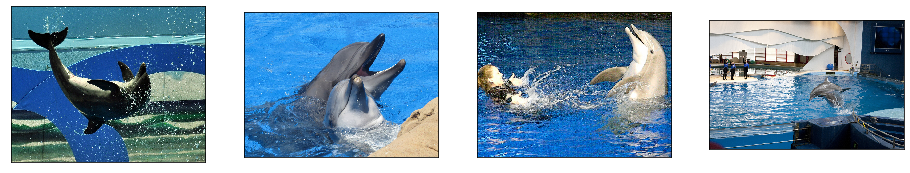

In [8]:
# show random sample images
imgtbl1.show(nimages=4, ncol=4, randomize=True)

In [9]:
# show summary metadata
imgtbl1.image_summary

jpg                    49
minWidth              400
maxWidth             1024
minHeight             258
maxHeight            1024
meanWidth         891.796
meanHeight        724.245
mean1stChannel    153.924
min1stChannel           0
max1stChannel         255
mean2ndChannel    123.969
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    70.0216
min3rdChannel           0
max3rdChannel         255
dtype: object

The image widths and heights are not uniform, and they vary in dimension from 258px to 1024px.

Now, show the noisy dolphin image table (`imgtbl2`) information:

In [10]:
# Check new 'imagtbl2'
# Imgtbl2 noisy_dolphin show headings 
imgtbl2.head()

Selected Rows from Table NOISY_DOLPHIN

                                             _image_ _label_  \
0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...           
1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...           
2  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...           
3  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...           
4  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...           

         _filename_0  _id_                                             _path_  \
0  dolphin_10091.jpg    26  /cas/DeepLearn/UserID/giraffe_dolphin_small/Do...   
1  dolphin_10004.jpg     1  /cas/DeepLearn/UserID/giraffe_dolphin_small/Do...   
2  dolphin_10005.jpg     2  /cas/DeepLearn/UserID/giraffe_dolphin_small/Do...   
3  dolphin_10088.jpg    24  /cas/DeepLearn/UserID/giraffe_dolphin_small/Do...   
4  dolphin_10191.jpg    45  /cas/DeepLearn/UserID/giraffe_dolphin_small/Do...   

   _size_  
0  189505  
1  170864  
2  239828  
3  793991  
4  819291

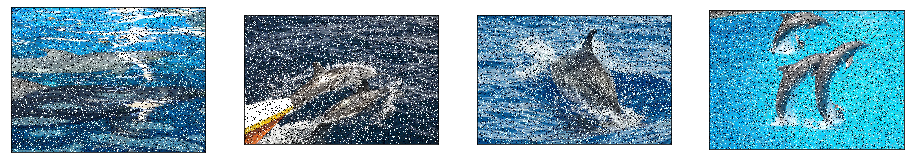

In [11]:
# show random sample images
imgtbl2.show(nimages=4, ncol=4, randomize=True)

In [12]:
# show summary metadata
imgtbl2.image_summary

jpg                    49
minWidth              400
maxWidth             1024
minHeight             258
maxHeight            1024
meanWidth         891.796
meanHeight        724.245
mean1stChannel    145.941
min1stChannel           0
max1stChannel         255
mean2ndChannel    123.912
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    84.3178
min3rdChannel           0
max3rdChannel         255
dtype: object

The displayed images are visually different in size. The table summaries show that the input image widths range from 400 to 1024 pixels, and the input image heights range from 258 to 1024 pixels. 

To create higher quality input data for modeling, the input images will be uniformly resized to 224 pixels by 224 pixels. Use the DLPy `resize()` function to standardize the image dimensions in both tables:

In [13]:
# Resize Images in both image tables to 224 x 224

# Resize clean dolphin images
imgtbl1.resize(224, 224, inplace=True)

# Resize noisy dolphin images
imgtbl2.resize(224, 224, inplace=True)

After resizing the images, display random images and summary tables for both the clean and noisy dolphin images:

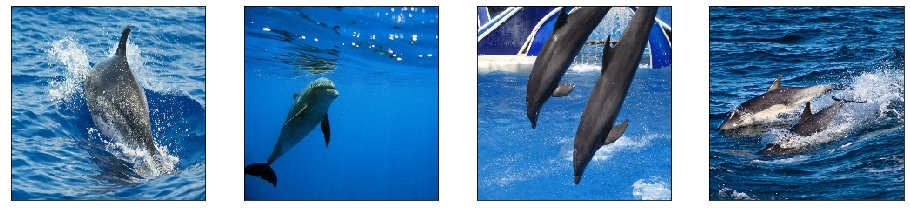

In [14]:
# show random images from the resized clean image table
imgtbl1.show(nimages=4, ncol=4, randomize=True)

In [15]:
# show summary statistics for the resized clean image table
imgtbl1.image_summary

jpg                    49
minWidth              224
maxWidth              224
minHeight             224
maxHeight             224
meanWidth             224
meanHeight            224
mean1stChannel    153.718
min1stChannel           0
max1stChannel         255
mean2ndChannel    123.848
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    70.2335
min3rdChannel           0
max3rdChannel         255
dtype: object

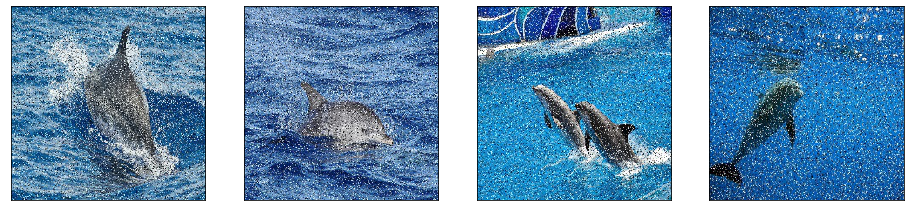

In [16]:
# show random images from the resized noisy image table
imgtbl2.show(nimages=4, ncol=4, randomize=True)

In [17]:
# show summary statistics for the resized clean image table
imgtbl2.image_summary

jpg                    49
minWidth              224
maxWidth              224
minHeight             224
maxHeight             224
meanWidth             224
meanHeight            224
mean1stChannel    145.573
min1stChannel           0
max1stChannel         255
mean2ndChannel    123.762
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    84.5627
min3rdChannel           0
max3rdChannel         255
dtype: object

The displayed images are visually the same size. The table summaries show that all images in both tables have been resized to 224 pixels by 224 pixels.

The new CAS tables have been inspected and all of the images are uniformly sized for model training data. 

<a id = "RenameColumns"></a>

### Rename the Image Column in the Clean Image Table

The contents of the clean and noisy CAS image tables will be used as training data for the image denoising model. The training data will be consolidated into a single table that contains information about both clean and noisy images. Both tables store the image data in a column named `_image_`. Rename the image data column in the clean image table from `_image_` to `outimage`. The merged table will contain clean image data in the column `outimage` and noisy image data in the column `_image_`.

Show the columns in the existing clean and noisy image tables before using the `altertable()` function to rename the column in the clean image table.

In [18]:
# Show the existing clean image table columns
imgtbl1.head()

Selected Rows from Table CLEAN_DOLPHIN

         _filename_0 _label_  \
0  dolphin_10004.jpg           
1  dolphin_10005.jpg           
2  dolphin_10006.jpg           
3  dolphin_10091.jpg           
4  dolphin_10119.jpg           

                                             _image_  _size_  \
0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   16831   
1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   24475   
2  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   16213   
3  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   12598   
4  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   35347   

                                              _path_  _id_  
0  /cas/DeepLearn/UserID/giraffe_dolphin_small/Do...     1  
1  /cas/DeepLearn/UserID/giraffe_dolphin_small/Do...     2  
2  /cas/DeepLearn/UserID/giraffe_dolphin_small/Do...     3  
3  /cas/DeepLearn/UserID/giraffe_dolphin_small/Do...    26  
4  /cas/DeepLearn/UserID/giraffe_dolphin_small/Do...    31

In [19]:
# Show the noisy image table columns
imgtbl2.head()

Selected Rows from Table NOISY_DOLPHIN

         _filename_0 _label_  \
0  dolphin_10091.jpg           
1  dolphin_10004.jpg           
2  dolphin_10005.jpg           
3  dolphin_10088.jpg           
4  dolphin_10191.jpg           

                                             _image_  _size_  \
0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   47521   
1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   44391   
2  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   44373   
3  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   44304   
4  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   48699   

                                              _path_  _id_  
0  /cas/DeepLearn/UserID/giraffe_dolphin_small/Do...    26  
1  /cas/DeepLearn/UserID/giraffe_dolphin_small/Do...     1  
2  /cas/DeepLearn/UserID/giraffe_dolphin_small/Do...     2  
3  /cas/DeepLearn/UserID/giraffe_dolphin_small/Do...    24  
4  /cas/DeepLearn/UserID/giraffe_dolphin_small/Do...    45

In [20]:
# Both tables have an '_image_' column

# In the clean image table, rename the
# '_image_' column to 'outimage'
s.table.altertable(columns=[{'rename':'outimage', 
                             'name':'_image_'}], 
                   name='clean_dolphin'
                  )

+ Elapsed: 0.000327s, user: 0.000237s, sys: 6.8e-05s, mem: 0.3mb

After running the function, check the clean image table structure. The `head()` function shows the new column heading `outimage`. The tables are ready for merging.

In [21]:
# Show the updated clean image table columns
imgtbl1.head()


Selected Rows from Table CLEAN_DOLPHIN

         _filename_0 _label_  \
0  dolphin_10004.jpg           
1  dolphin_10005.jpg           
2  dolphin_10006.jpg           
3  dolphin_10091.jpg           
4  dolphin_10119.jpg           

                                            outimage  _size_  \
0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   16831   
1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   24475   
2  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   16213   
3  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   12598   
4  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   35347   

                                              _path_  _id_  
0  /cas/DeepLearn/UserID/giraffe_dolphin_small/Do...     1  
1  /cas/DeepLearn/UserID/giraffe_dolphin_small/Do...     2  
2  /cas/DeepLearn/UserID/giraffe_dolphin_small/Do...     3  
3  /cas/DeepLearn/UserID/giraffe_dolphin_small/Do...    26  
4  /cas/DeepLearn/UserID/giraffe_dolphin_small/Do...    31

<a id = "MergeTables"></a>

### Merge Clean and Noisy Image Tables Into a Single CAS Table

The CAS `clean_dolphin` table `tbl1` and the CAS `noisy_dolphin` table `tbl2` are ready to be merged into a single CAS table. The merged table will contain clean and noised versions of all input images. 

The merged table `traindata` created in the code below has two image columns. The column named `_image_` contains the noisy  images. The column named `_outimage_` contains the corresponding ground truth clean images. 

In [22]:
# Load the deepLearn CAS action set
s.loadactionset('deeplearn')

# The DLPy dljoin() function joins the annotated table 
# 'clean_dolphin' with the table 'noisy_dolphin'.
s.deeplearn.dljoin(annotatedtable=dict(name = 'clean_dolphin', 
                                       importOptions='auto'
                                      ), 
                   table='noisy_dolphin', 
# Merged table is named 'traindata'
                   casout=dict(name='traindata', 
                               replace=True), 
                   id='_filename_0'
                  )

NOTE: Added action set 'deeplearn'.


[OutputCasTables]

             casLib       Name  Rows  Columns  \
 0  CASUSER(UserID)  traindata    49        7   
 
                                           casTable  
 0  CASTable('traindata', caslib='CASUSER(UserID)')  

+ Elapsed: 0.0188s, user: 0.0181s, sys: 0.0192s, mem: 162mb

<a id = "CompareImages"></a>

### Compare Noisy and Clean Images 

Take a look at the noisy images and their clean counterparts. Use the DLPy `fetchImages()` function to create small result tables named `train_imgs` and `train_outimage`. They will both contain the first four images from the `traindata` input data: noisy images in `train_imgs` and clean images in `train_outimage`. Then, use matplotlib to display to display the clean and noisy images in 4 x 2 image tables. 

In [23]:
# Create 'train_imgs' table with the first 
# four noisy images in 'traindata'
train_imgs = s.fetchImages(
    table='traindata',
    to=4,
    image='_image_'
     ) 
# Create 'train_outimage' table with the first 
# four clean images in 'traindata'
train_outimage = s.fetchImages(
    table='traindata',
    to=4,
    image='outimage'
     ) 

NOTE: Table TRAINDATA contains compressed images.
NOTE: Table TRAINDATA contains compressed images.


Display and compare plots of the first four noisy and clean images: 

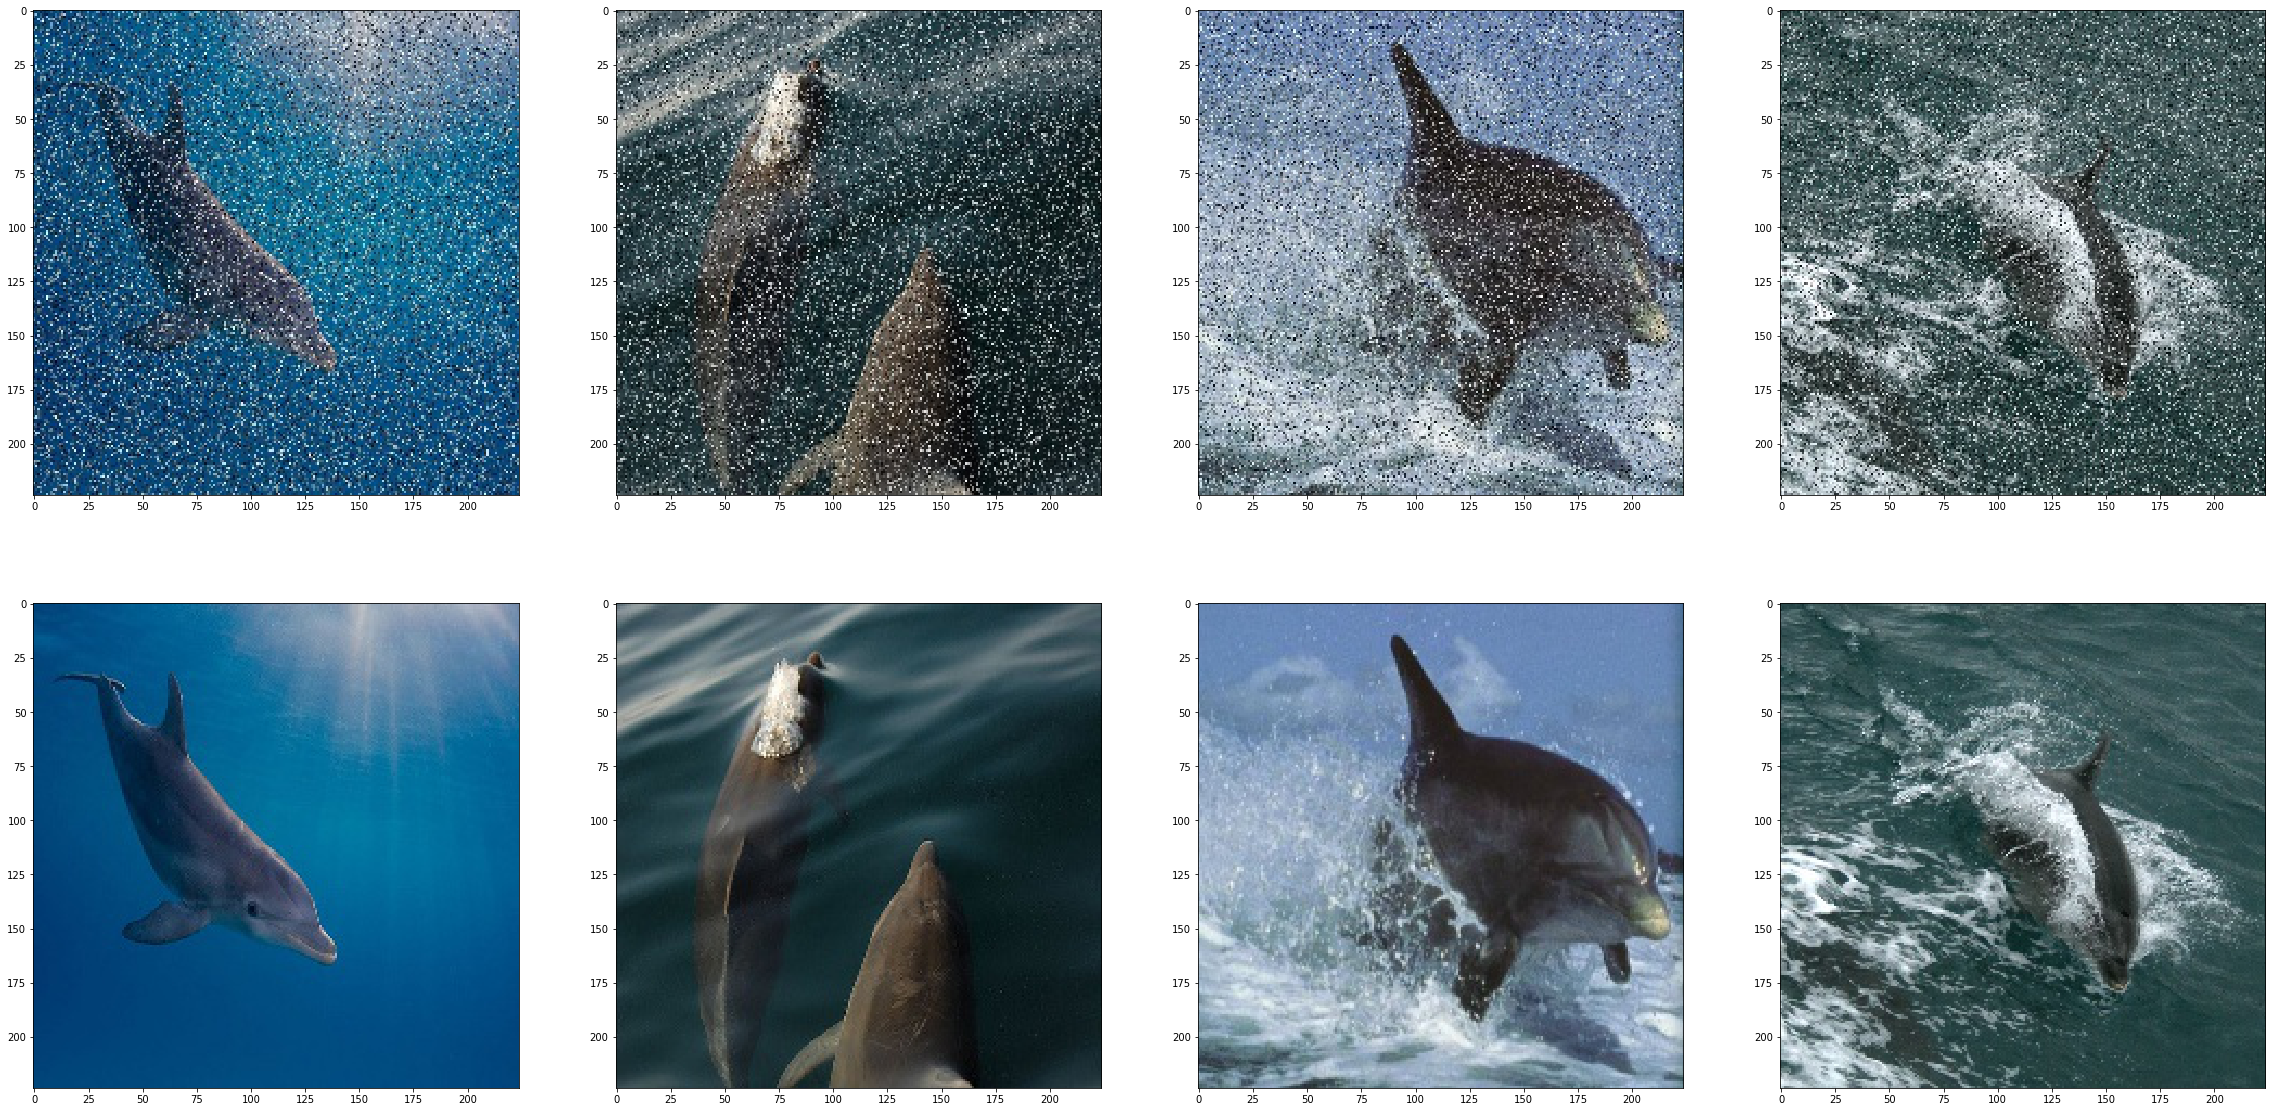

In [24]:
# Use matplotlib to display the first four 
# noisy and corresponding clean dolphin images
fig = plt.figure(figsize = (40, 20))
k = 1

# output images in two rows
n_row = 2
# output images in four columns
n_col = 4

# display first 4 noisy images
for i in range(4):
    ax = fig.add_subplot(n_row, n_col, k)
    plt.imshow(train_imgs['Images']['Image'][i])
    k = k + 1    
    
# display first 4 clean images    
for i in range(4):
    ax = fig.add_subplot(n_row, n_col, k)
    plt.imshow(train_outimage['Images']['Image'][i])
    k = k + 1

<a id = "DefineDenoising"></a>

### Use SAS DLPy to Define the Image Denoising Model Architecture

The input data to train the image denoising model is ready. Now use SAS DLPy to define the architecture of an image denoising model that uses a pixel-wise segmentation regression algorithm. :

In [25]:
# Image Denoising Model 'Segmentation_1'

# nf notification specification
nf = 1024

# Specify the layer-by-layer structure for the image denoisiong model
# Input Layer
data_input = Input(n_channels=3, width=224, height=224, name='Input', scale = 1.0 / 255)             

# Encoder network
# Convolution and Pooling layers
conv_1 = Conv2d(n_filters=nf, width=3, height=3, stride=1, padding=1, act='elu')(data_input)         
pool_1 = Pooling(width=2, height=2, stride=2, padding=0, pool='max')(conv_1) 
conv_2 = Conv2d(n_filters=nf/2, width=3, height=3, stride=1, padding=1, act='elu')(pool_1)           
pool_2 = Pooling(width=3, height=3, stride=1, padding=0, pool='max')(conv_2)                         
conv_3 = Conv2d(n_filters=nf/2, width=3, height=3, stride=1, padding=1, act='elu')(pool_2)          
pool_3 = Pooling(width=3, height=3, stride=1, padding=0, pool='max')(conv_3) 
conv_5 = Conv2d(n_filters=nf/2, width=3, height=3, stride=1, padding=1, act='elu')(pool_3)           

# Encoder layer
encoder = Pooling(width=3, height=3, stride=2, padding=1, pool='max', name='encoder')(conv_5)        

# Decoder network
# Convolution and Transpose Convolution layers  
conv_7 = Conv2d(n_filters=nf/2, width=3, height=3, stride=1, padding=1, act='elu')(encoder)          
upsample_1 = Conv2DTranspose(nf/2, 4, padding=1, stride=2, act='relu')(conv_7)                       
conv_8 = Conv2d(n_filters=nf/2, width=3, height=3, stride=1, padding=1, act='elu')(upsample_1)       
upsample_2 = Conv2DTranspose(nf/2, 3, padding=0, stride=1, act='relu')(conv_8)                       
conv_9 = Conv2d(n_filters=nf/2, width=3, height=3, stride=1, padding=1, act='elu')(upsample_2)       
upsample_3 = Conv2DTranspose(nf/2, 3, padding=0, stride=1, act='relu')(conv_9)                       
conv_10 = Conv2d(n_filters=nf, width=3, height=3, stride=1, padding=1, act='elu')(upsample_3)        
upsample_4 = Conv2DTranspose(nf, 4, padding=1, stride=2, act='relu')(conv_10)                        
conv_11 = Conv2d(n_filters=nf, width=3, height=3, stride=1, padding=1, act='elu')(upsample_4)   

# Decoder layer
decoder = Conv2d(n_filters=3, width=3, height=3, stride=1, 
                 padding=1, act='logistic', name='decoder')(conv_11)  

# Model segmentation parameters 
seg1 = Segmentation(name='Segmentation_1', target_scale = 1.0 / 255, error='normal')(decoder)                      

# Create image denoising model 'model'
model = Model(s, inputs=data_input, outputs=seg1, model_table='auto_encoder')

# Compile the image denoising model
model.compile()

# Display a summary of the new image denoising model 'model'
model.summary

NOTE: Model compiled successfully.


Layer Id              Layer          Type Kernel Size  Stride Activation  \
0          0              Input         input                           None   
1          1           Conv2d_1         convo      (3, 3)  (1, 1)        Elu   
2          2          Pooling_1          pool      (2, 2)  (2, 2)        Max   
3          3           Conv2d_2         convo      (3, 3)  (1, 1)        Elu   
4          4          Pooling_2          pool      (3, 3)  (1, 1)        Max   
5          5           Conv2d_3         convo      (3, 3)  (1, 1)        Elu   
6          6          Pooling_3          pool      (3, 3)  (1, 1)        Max   
7          7           Conv2d_4         convo      (3, 3)  (1, 1)        Elu   
8          8            encoder          pool      (3, 3)  (2, 2)        Max   
9          9           Conv2d_5         convo      (3, 3)  (1, 1)        Elu   
10        10  Conv2DTranspose_1    transconvo      (4, 4)  (2, 2)       Relu   
11        11           Conv2d_6         convo      (3, 3)  (1, 1)        Elu   
12        12  Conv2DTranspose_2    transconvo      (3, 3)  (1, 1)       Relu   
13        13           Conv2d_7         convo      (3, 3)  (1, 1)        Elu   
14        14  Conv2DTranspose_3    transconvo      (3, 3)  (1, 1)       Relu   
15        15           Conv2d_8         convo      (3, 3)  (1, 1)        Elu   
16        16  Conv2DTranspose_4    transconvo      (4, 4)  (2, 2)       Relu   
17        17           Conv2d_9         convo      (3, 3)  (1, 1)        Elu   
18        18            decoder         convo      (3, 3)  (1, 1)   Logistic   
19        19     Segmentation_1  segmentation                           None   

         Output Size Number of Parameters  FLOPS(forward pass)  
0      (224, 224, 3)               (0, 0)                    0  
1   (224, 224, 1024)        (27648, 1024)           1387266048  
2   (112, 112, 1024)               (0, 0)                    0  
3    (112, 112, 512)       (4718592, 512)          59190018048  
4    (110, 110, 512)               (0, 0)                    0  
5    (110, 110, 512)       (2359296, 512)          28547481600  
6    (108, 108, 512)               (0, 0)                    0  
7    (108, 108, 512)       (2359296, 512)          27518828544  
8      (54, 54, 512)               (0, 0)                    0  
9      (54, 54, 512)       (2359296, 512)           6879707136  
10   (108, 108, 512)       (4194304, 512)          48922361856  
11   (108, 108, 512)       (2359296, 512)          27518828544  
12   (110, 110, 512)       (2359296, 512)          28547481600  
13   (110, 110, 512)       (2359296, 512)          28547481600  
14   (112, 112, 512)       (2359296, 512)          29595009024  
15  (112, 112, 1024)      (4718592, 1024)          59190018048  
16  (224, 224, 1024)     (16777216, 1024)         841813590016  
17  (224, 224, 1024)      (9437184, 1024)         473520144384  
18     (224, 224, 3)           (27648, 3)           1387266048  
19     (224, 224, 3)               (0, 0)                    0

<a id = "ShufflePartition"></a>

### Shuffle the Merged Data and Partition into Train and Validation Tables

Next, use the DLPy `shuffle()` and `two_way_split()` functions to randomize observations in table `traindata` and partition it into test and validataion tables. The tables are partitioned by putting 10 percent of the observations into the validation portion `te_img`, and then putting the remaining 90 percent of the observations into the training partion `tr_img`.

In [26]:
# Shuffle the rows in the CAS table 'traindata' and 
# name the shuffled table 'data_input'
s.shuffle(table='traindata', 
          casout=dict(name='data_input', 
                      replace=True)
         )
# Use shuffled table 'data_input' to partition new
# 90% train, 10% test tables 'tr_img' and 'te_inmg'
image_data = s.CASTable('data_input')
tr_img, te_img = two_way_split(image_data, 
                               test_rate=10, 
                               seed=902, 
                               columns=['outimage']
                              )

Display the train partition table structure:

In [27]:
tr_img.head()

Selected Rows from Table TRAIN_R0NDB8

                                             _image_ _label_  \
0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...           
1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...           
2  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...           
3  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...           
4  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...           

         _filename_0  _id_                                           outimage  
0  dolphin_10052.jpg    12  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  
1  dolphin_10006.jpg     3  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  
2  dolphin_10175.jpg    41  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  
3  dolphin_10109.jpg    30  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  
4  dolphin_10158.jpg    37  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...

Display the validation (test) partition table structure:

In [28]:
te_img.head()

Selected Rows from Table TEST_KBHSIR

                                             _image_ _label_  \
0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...           
1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...           
2  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...           
3  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...           
4  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...           

         _filename_0  _id_                                           outimage  
0  dolphin_10078.jpg    20  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  
1  dolphin_10104.jpg    27  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  
2  dolphin_10046.jpg     9  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  
3  dolphin_10069.jpg    17  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  
4  dolphin_10132.jpg    34  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...

<a id = "TrainModel"></a>

### Train the Image Denoising Model

Now use the partitioned data in `tr_img` to train the image denoising model named `model`.

In [29]:
# Train the image denoising model

# Import DLPy learning rate scheduler functions
from dlpy.lr_scheduler import *

# Use dataspecs to define the input and output
# layer parameter values
data_specs = [DataSpec(type_='IMAGE', layer='Input', data=['_image_']),
              DataSpec(type_='IMAGE', layer='Segmentation_1', data=['outimage'])]

# Set fixed learning rate of 1E-4
lr_scheduler = FixedLR(learning_rate=0.0001)

# Adam solver parameter settings
solver = AdamSolver(lr_scheduler=lr_scheduler, 
                    clip_grad_max = 100, 
                    clip_grad_min = -100, 
                    beta1=0.85, 
                    beta2=0.85)

# Solver optimizer parameters settings
optimizer = Optimizer(algorithm=solver, 
                      mini_batch_size=40, 
                      log_level=2, 
                      max_epochs=250, 
                      reg_l2=0.001, 
                      reg_l1=0.001,
                      seed=18893)

# Model train settings
r = model.fit(data = tr_img, 
              valid_table=te_img,
              data_specs=data_specs, 
              optimizer=optimizer, 
              force_equal_padding=True, 
              n_threads=1, 
              gpu=dict(devices=[0,1])
             )

The following argument(s) learning_rate, learning_rate_policy, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.
NOTE: Training from scratch.
NOTE: Using your-server.unx.your-company.com: 2 out of 2 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 56424963.
NOTE:  The approximate memory cost is 22036.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost      18.31 (s).
NOTE:  The total number of threads on each worker is 1.
NOTE:  The total mini-batch size per thread on each worker is 40.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 40.
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation Loss Validation Error   Time(s)
NOTE:  0        0.0001            4989     0.2097        1.172e+04           0.3048    86.70
NOTE:  1        

NOTE:  78       0.0001           805.9    0.07392              937          0.08158     6.09
NOTE:  79       0.0001           718.8    0.07272             1136          0.09172     6.09
NOTE:  80       0.0001           927.7    0.08463            952.1          0.08599     6.10
NOTE:  81       0.0001            1041    0.08867             1604           0.1137     6.09
NOTE:  82       0.0001            1162    0.09624             1143          0.09434     6.09
NOTE:  83       0.0001            1012    0.08923             1014          0.08518     6.08
NOTE:  84       0.0001           893.4    0.08082             1004          0.08461     6.09
NOTE:  85       0.0001           904.4    0.08073            994.3          0.08544     6.09
NOTE:  86       0.0001             843    0.07802            880.9          0.08022     6.10
NOTE:  87       0.0001           721.2    0.07221            918.3          0.08014     6.10
NOTE:  88       0.0001           804.2    0.07469            904.8    

NOTE:  172      0.0001           561.7    0.06403            759.7           0.0723     6.09
NOTE:  173      0.0001           606.9    0.06444            773.5           0.0739     6.10
NOTE:  174      0.0001           599.7    0.06387            725.5          0.07164     6.09
NOTE:  175      0.0001           542.6    0.06099              701          0.06903     6.09
NOTE:  176      0.0001           506.1    0.05744            694.5          0.06882     6.09
NOTE:  177      0.0001           543.5    0.06092            746.1          0.07324     6.09
NOTE:  178      0.0001           541.9     0.0607              705          0.06932     6.10
NOTE:  179      0.0001           539.9    0.06025            744.2          0.07235     6.10
NOTE:  180      0.0001           596.5    0.06454            842.9          0.07794     6.09
NOTE:  181      0.0001             580    0.06374            866.1          0.08017     6.10
NOTE:  182      0.0001           633.9    0.06674            765.9    

Now use the DLPy `plot_training_history()` function to display the iterative statistics for model training loss, validation loss, fit error, and validation error.

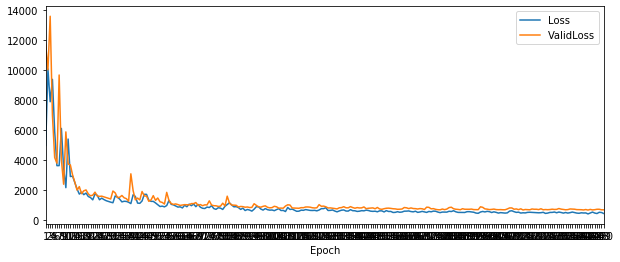

In [30]:
model.plot_training_history(items=['Loss', 'ValidLoss'],fig_size=(10,4))

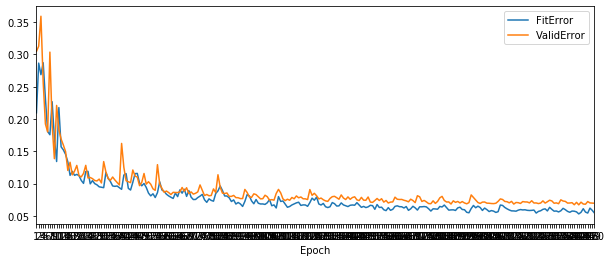

In [31]:
model.plot_training_history(items=['FitError', 'ValidError'],fig_size=(10,4))

<a id = "ModelPredict"></a>

### Use the Image Denoising Model to Score Test Images

Now use the trained image denoising model `model` to score noisy images in the test data set and predict the appearance of the images without the noise.

In [32]:
# Score the Test data 'te_img'
model.predict(te_img, 
              gpu=dict(devices=[1])
             )

NOTE: Due to data distribution, miniBatchSize has been limited to 1.
NOTE: Using your-server.unx.your-company.com: 1 out of 2 available GPU devices.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read             5
 1  Number of Observations Used             5
 2          Mean Absolute Error      0.069517
 3                   Loss Error      693.4074

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(UserID)  Valid_Res_iEFq84     5   150533   
 
                                             casTable  
 0  CASTable('Valid_Res_iEFq84', caslib='CASUSER(c...  

+ Elapsed: 39.8s, user: 12.3s, sys: 4.43s, mem: 2.44e+05mb

<a id = "RenameValid"></a>

### Rename the Image Column in the Validation Table
This step renames the `_image_` column in the validation data table to `_newimage_`.  The `_newimage_` column is used to create images from pixel intensities in the next step.

In [33]:
s.table.altertable(columns=[{'rename':'_newimage_', 'name':'_image_'}], 
                   name=model.valid_res_tbl.name)

+ Elapsed: 0.000404s, user: 0.000284s, sys: 9.2e-05s, mem: 0.3mb

<a id = "PixelIntensity"></a>

### Display Denoising Image Column Results Generated from Pixel Intensity Values

The image denoising model `model` outputs predicted image results in a one column per pixel format. The one column per pixel information is converted into a blob format using the SAS CAS action `condenseImages()`.
The output table is named `outimagetbl`.

In [34]:
# Use 'condenseImages()' to convert pixel 
# value columns into a viewable blob format
s.image.condenseImages(casout={'name':'outimagetbl', 'replace':True} ,
                       table={'name':model.valid_res_tbl.name}, 
                       numberOfChannels='COLOR_IMAGE',
                       height=224, 
                       width=224, 
                       copyvars=['_filename_0', 'outimage', '_newimage_'], 
                       groupedChannels=True
                      )

NOTE: 5 out of 5 images were processed successfully and saved to the Cloud Analytic Services table outimagetbl.


[OutputCasTables]

             casLib         Name Label  Rows  Columns  \
 0  CASUSER(UserID)  outimagetbl           5        7   
 
                                             casTable  
 0  CASTable('outimagetbl', caslib='CASUSER(UserID)')  

+ Elapsed: 1.82s, user: 1.48s, sys: 0.424s, mem: 1.03e+03mb

<a id = "DisplayOutputCols"></a>

### Display Output Table Image Columns

Dislpay the three image columns in the output table: the input (_newimage_) column, the predicted (_image_) column, and the ground truth (outimage) column.

In [35]:
# Display Output Table Image Columns
s.columninfo('outimagetbl')

[ColumnInfo]

         Column Label  ID              Type  RawLength  FormattedLength Format  \
 0      _image_         1  varbinary(image)      20606            20606          
 1       _size_         2             int64          8               12          
 2  _filename_0         3           varchar         17               17          
 3     outimage         4  varbinary(image)      38540            38540          
 4   _newimage_         5  varbinary(image)      50027            50027          
 5         _id_         6             int64          8               12          
 6      _label_         7           varchar          0                1          
 
    NFL  NFD  
 0    0    0  
 1    0    0  
 2    0    0  
 3    0    0  
 4    0    0  
 5    0    0  
 6    0    0  

+ Elapsed: 0.000636s, user: 0.000606s, mem: 0.82mb

<a id = "DisplayOutputs"></a>

###  Display Scored Table Results

This step uses the SAS DLPy `fetchImages()` function and matplotlib code to display images from the scored imag model output table. Each prediction contains the noisy input image, the ground truth image, and the predicteded output image. First, build the three sample tables `test_newimage` for noisy images, `test_outimage` for ground truth images, and `test_imgs` for predictied images:

In [36]:
# Use 'test_newimage' and fetch the 
# first four noisy input images
test_newimage = s.fetchImages(table='outimagetbl',
                              to=4,
                              image='_newimage_'
                             )

# Use 'test_outimage' and fetch the 
# first four ground truth images
test_outimage = s.fetchImages(table='outimagetbl',
                              to=4,
                              image='outimage'
                             )

# Use 'test_imgs' and fetch the 
# first four predicted images
test_imgs = s.fetchImages(table='outimagetbl',
                          to=4,
                          image='_image_'
                         )

NOTE: Table OUTIMAGETBL contains compressed images.
NOTE: Table OUTIMAGETBL contains compressed images.
NOTE: Table OUTIMAGETBL contains compressed images.


Now, use matplotlib code to display the output with noisy images, ground truth images, and predicted images:

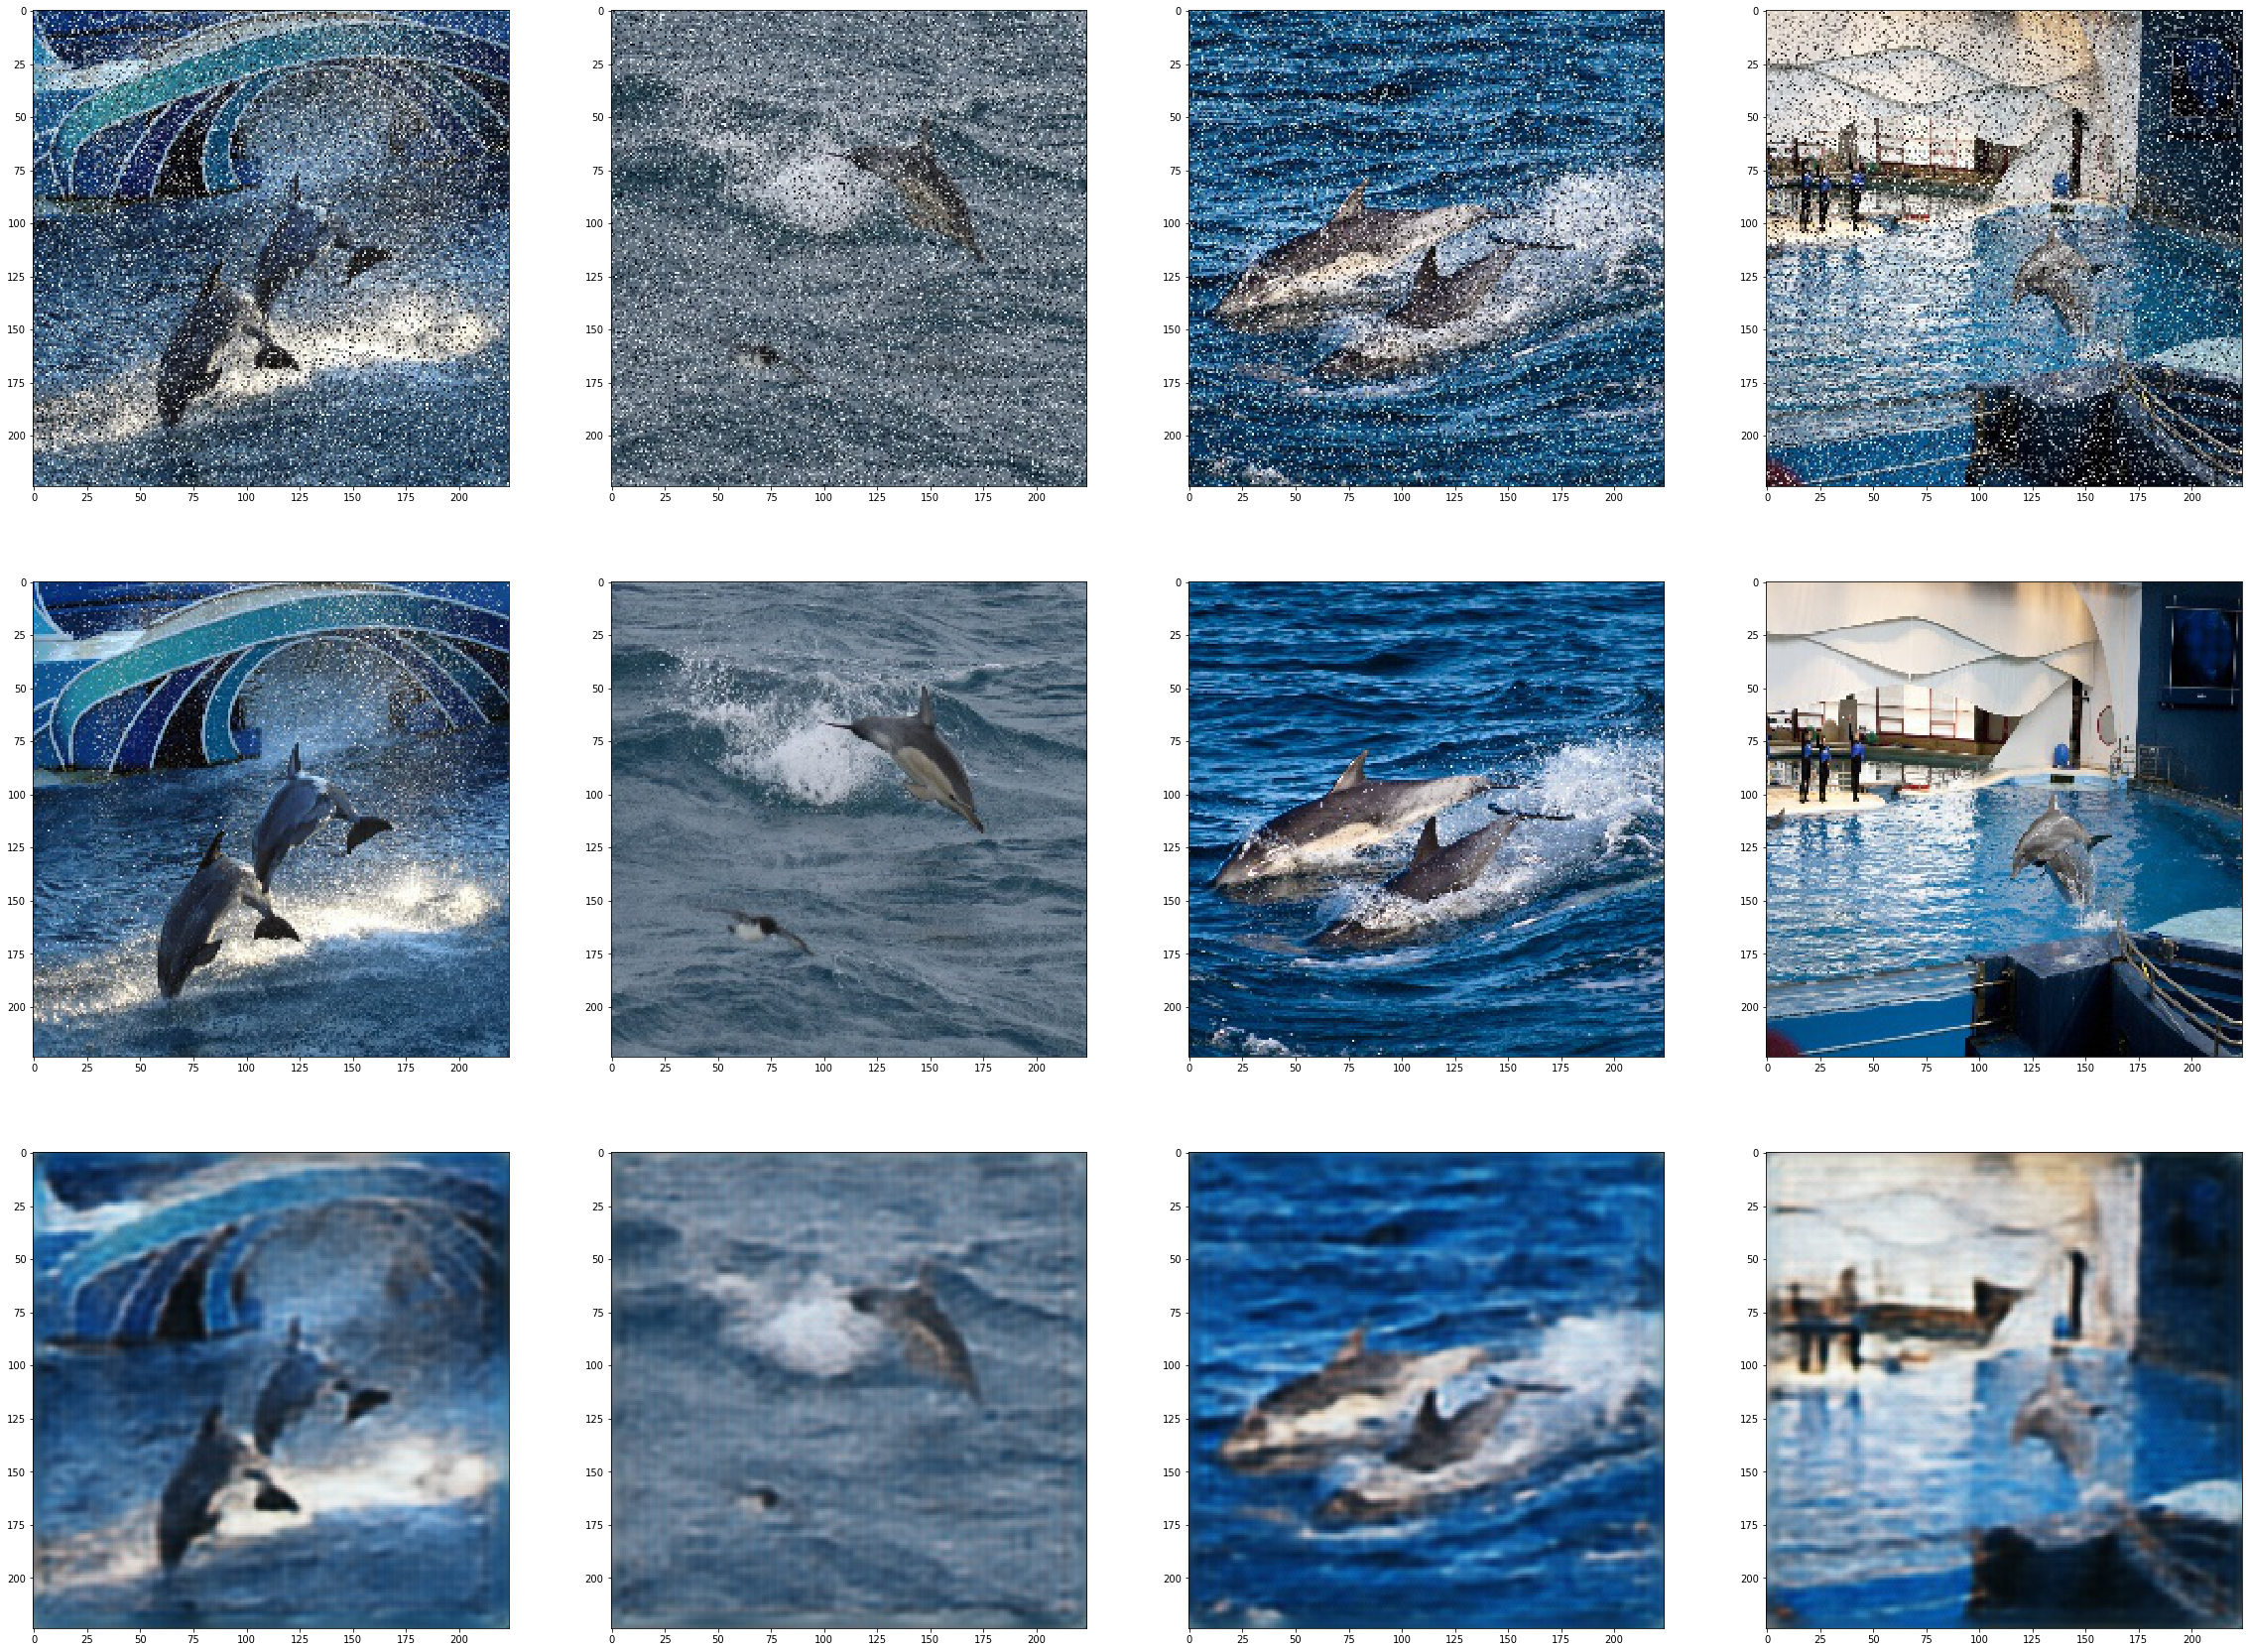

In [39]:
# matplotlib output image prediction plots
# Specify plot parameters
fig = plt.figure(figsize = (40, 30))
k = 1
n_row = 3
n_col = 4

# Noisy input images   
for i in range(4):
    ax = fig.add_subplot(n_row, n_col, k)
    plt.imshow(test_newimage['Images']['Image'][i])
    k = k + 1

# Ground truth images    
for i in range(4):
    ax = fig.add_subplot(n_row, n_col, k)
    plt.imshow(test_outimage['Images']['Image'][i])
    k = k + 1
    
# Predicted images
for i in range(4):
    ax = fig.add_subplot(n_row, n_col, k)
    plt.imshow(test_imgs['Images']['Image'][i])
    k = k + 1    



In [ ]:
s.endsession()